In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
import datetime
#sns.set(color_codes=True)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import statistics as st
sns.set_style('whitegrid', {'axes.linewidth' : 0.5})
from statsmodels.distributions.empirical_distribution import ECDF
import scipy
import gc

from helpers import *

In [2]:
today_str = dt.datetime.today().strftime('%y%m%d')

In [3]:
def curve(startx, starty, endx, endy):
    x1 = np.linspace(0,(endx-startx),100)
    x2 = x1+startx
    x = x1/(endx-startx)
    y = (endy-starty)*(6*x**5-15*x**4+10*x**3)+starty
    y = (endy-starty)*(-20*x**7+70*x**6-84*x**5+35*x**4)+starty
    return x2, y

In [4]:
curative = pd.read_csv('~/Box/covid_CDPH/2021.07.06 Master Set Data Only_Deidentified.csv', encoding= 'unicode_escape')
curative['patient_symptom_date'] = pd.to_datetime(curative['patient_symptom_date'], errors='coerce')
curative['collection_time'] = pd.to_datetime(curative['collection_time'], errors='coerce')
curative['days'] = (pd.to_datetime(curative['collection_time'], utc=True) - pd.to_datetime(curative['patient_symptom_date'], utc=True)).dt.days

C:\Users\Ibis Grad\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,4,10,11,13,15,16,18,19,20,21,22,23,24,25,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
idph =  pd.read_csv('~/Box/covid_IDPH/sentinel_surveillance/210706_SS_epic.csv', encoding= 'unicode_escape')
idph['test_date'] = pd.to_datetime(idph['test_date'])
idph['test_time'] = pd.to_datetime(idph['test_time'])
idph['date_symptoms_start'] = pd.to_datetime(idph['date_symptoms_start'])
idph['days'] = (idph['test_date'] - idph['date_symptoms_start']).dt.days
ss_cond = (idph['days'] <= 4) & (idph['days'] >= 0)
pos_cond = (idph['result'] == 'DETECTED') | (idph['result'] == 'POSITIVE')  | (idph['result'] == 'Detected')
chi_cond = (idph['test_site_city'] == 'CHICAGO')

In [9]:
zips = pd.read_csv('./data/Chicago_ZIP_codes.txt', header=None)[0].values

In [10]:
idph['chicago'] = idph['pat_zip_code'].apply(lambda x: zip_in_zips(x, zips))

In [11]:
curative['chicago'] = curative['patient_city'] == 'Chicago'

In [12]:
curative_time_frame_cond = (curative['collection_time'] >= pd.to_datetime('9-27-20')) & (curative['collection_time'] <= pd.to_datetime('6-13-21'))
curative_ss = (curative['days'] >= 0) & (curative['days'] <= 4)
curative_symptom = curative['patient_is_symptomatic']

idph_time_frame_cond = (idph['test_date'] >= pd.to_datetime('9-27-20')) & (idph['test_date'] <= pd.to_datetime('6-13-21'))
idph_ss = (idph['days'] >= 0) & (idph['days'] <= 4)
idph_symptom = idph['symptomatic_per_cdc'] == 'Yes'
idph_chicago_site = (idph['test_site'] == 'IDPH COMMUNITY TESTING AUBURN GRESHAM') | (idph['test_site'] == 'IDPH AUBURN GRESHAM COMMUNITY TESTING') | (idph['test_site'] == 'IDPH HARWOOD HEIGHTS COMMUNITY TESTING')

idph_count = np.sum(idph_time_frame_cond & idph_ss & idph['chicago'] & idph_chicago_site)
curative_count = np.sum(curative_time_frame_cond & curative_ss & curative['chicago'])

pos_cond_curative = curative['test_result'] == 'POSITIVE'
curative['positive'] = pos_cond_curative
chi_idph = (idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')
pos_cond_idph = (idph['result'] == 'DETECTED') | (idph['result'] == 'POSITIVE')  | (idph['result'] == 'Detected')
idph['positive'] = pos_cond_idph

print(idph_count)
print(curative_count)

7478
6474


In [13]:
print('Tests collected at sentinel sites in study period: ')
sentinel_sites_total = len(curative[curative_time_frame_cond]) + len(idph[idph_time_frame_cond & idph_chicago_site])
print(sentinel_sites_total)

print('with Chicago residence: ')
chicago_residents = len(curative[curative_time_frame_cond & curative['chicago']]) + \
len(idph[idph_time_frame_cond & idph_chicago_site & idph['chicago']])
print(chicago_residents)

print('with valid symptom date: ')
with_symptom_date = len(curative[curative_time_frame_cond & curative['chicago']].dropna(subset=['days'])) + \
len(idph[idph_time_frame_cond & idph_chicago_site & idph['chicago']].dropna(subset=['days']))
print(with_symptom_date)

print('symptom date 4 or fewer days before test: ')
tot_ss = len(curative[curative_time_frame_cond & curative['chicago'] & curative_ss].dropna(subset=['days'])) + \
len(idph[idph_time_frame_cond & idph_chicago_site & idph['chicago'] & idph_ss].dropna(subset=['days']))
print(tot_ss)

print('and positive: ')
tot_sc = len(curative[curative_time_frame_cond & curative['chicago'] & curative_ss & pos_cond_curative].dropna(subset=['days'])) + \
len(idph[idph_time_frame_cond & idph_chicago_site & idph['chicago'] & idph_ss & pos_cond_idph].dropna(subset=['days']))
print(tot_sc)

Tests collected at sentinel sites in study period: 
324872
with Chicago residence: 
274934
with valid symptom date: 
21406
symptom date 4 or fewer days before test: 
13952
and positive: 
3607


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


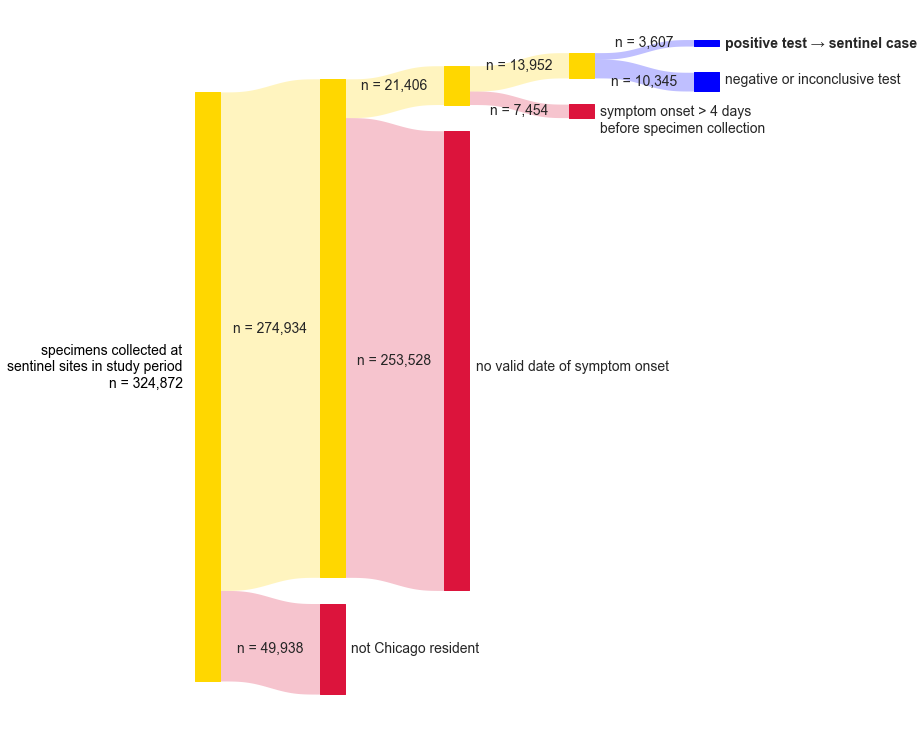

In [116]:
h = 10
w = 8

fig = plt.figure(figsize=(w, h))

figh = h-0
figw = w-0

ax = fig.add_axes([0,0,figw/w,figh/h])

stop_location = np.arange(0,5,1)
line_width = 0.05
#ax.set_xlim([-0.05,1.05])
h_padding = 0.15
v_padding = 0.2
line_width = 0.2
line_height = 4.5
midpoint = (v_padding + line_height)/2

tot_height = sentinel_sites_total

ax.fill_between([stop_location[0], stop_location[0]+line_width], 
                  [midpoint+line_height/2]*2, 
                  [midpoint-line_height/2]*2, 
                  color='gold', zorder=15)

#ax.text(x=stop_location[0]+line_width/1.75, 
#          y=midpoint, s="specimens collected at sentinel sites in study period n = " + "{:,}".format(sentinel_sites_total), 
#          ha='center', va='center', 
#          rotation=90, zorder=16, color='k', fontsize=14)

splits = [chicago_residents, with_symptom_date, tot_ss, tot_sc]
d = tot_height
splits_array = np.array(splits)/d
d_t = 1
d_ts = d
d_top = midpoint+line_height/2
d_bot = midpoint-line_height/2
d_x = stop_location[0]
# midpoint = figh/2

include_color_array = ['gold']*(len(splits)-1) + ['blue']
exclude_color_array = ['crimson']*(len(splits)-1) + ['blue']

for s, l_l, s1, include_color, exclude_color in zip(splits_array, 
                                                    stop_location[1:], 
                                                    splits, 
                                                    include_color_array, 
                                                    exclude_color_array):
    
    t_line = line_height*d_t + v_padding
    
    ax.fill_between([l_l, l_l+line_width], 
                      [midpoint+t_line/2]*2, 
                      [midpoint+t_line/2-line_height*s]*2, 
                      color=include_color, zorder=13)
    
    ax.fill_between([l_l, l_l+line_width], 
                      [midpoint-t_line/2]*2, 
                      [midpoint-t_line/2+line_height*(d_t-s)]*2, 
                      color=exclude_color)
    
    
    a1 = curve(d_x+line_width, d_bot, 
               l_l, midpoint-t_line/2)
    a2 = curve(d_x+line_width, d_bot+line_height*(d_t-s), 
               l_l, midpoint-t_line/2+line_height*(d_t-s))
    
    ax.fill_between(a1[0], a1[1], a2[1], color=exclude_color, alpha=0.25, linewidth=0)
    
    ax.text((d_x+l_l+line_width)/2, 
                  midpoint+t_line/2-line_height*(s)/2, 
                  "n = "+"{:,}".format(s1), 
                  ha='center', va='center', 
                  rotation=0, fontsize=14)
    
    ax.text((d_x+l_l+line_width)/2, 
                  midpoint-t_line/2+line_height*(d_t-s)/2, 
                  "n = "+"{:,}".format(d_ts - s1), 
                  ha='center', va='center', 
                  rotation=0, fontsize=14)
    
    a1 = curve(d_x+line_width, d_top, 
               l_l, midpoint+t_line/2)
    a2 = curve(d_x+line_width, d_bot+line_height*(d_t-s), 
               l_l, midpoint+t_line/2-line_height*s)
    
    ax.fill_between(a1[0], a1[1], a2[1], color=include_color, alpha=0.25, linewidth=0)
    
    d_t = s
    d_ts = s1
    d_top = midpoint+t_line/2
    d_bot = midpoint+t_line/2-line_height*s
    d_x = l_l
    midpoint = midpoint+t_line/2-line_height*s/2
    
ax.text(x=stop_location[1]+line_width+0.05, y=0.35, s='not Chicago resident', 
          ha='left', va='center', fontsize=14)
ax.text(x=stop_location[2]+line_width+0.05, y=2.5, s='no valid date of symptom onset', 
          ha='left', va='center', fontsize=14)
ax.text(x=stop_location[3]+line_width+0.05, y=4.5, s='symptom onset > 4 days\nbefore specimen collection', 
          ha='left', va='top', fontsize=14)
ax.text(x=stop_location[4]+line_width+0.05, y=5.02, s="positive test → sentinel case", 
          ha='left', va='top', fontsize=14, weight='bold')
ax.text(x=stop_location[4]+line_width+0.05, y=4.75, s="negative or inconclusive test", 
          ha='left', va='top', fontsize=14)
ax.text(x=stop_location[0]-0.1, 
          y=2.5, s="specimens collected at\nsentinel sites in study period\nn = " + "{:,}".format(sentinel_sites_total), 
          ha='right', va='center', 
          rotation=0, zorder=16, color='k', fontsize=14)

ax.grid(False)
ax.axis('off')
fig.savefig('sankey_diagram_' + today_str + '.png', dpi=200, bbox_inches='tight')
fig.savefig('sankey_diagram_' + today_str + '.pdf', bbox_inches='tight')